In [3]:
%load_ext autoreload
%autoreload 2

import os.path
import numpy as np

# Load in data, this assumed you have a folder in env named data
data_dir = "data"
X_test = np.load(os.path.join(data_dir, "X_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))
person_test = np.load(os.path.join(data_dir, "person_test.npy")).squeeze(axis=1)
X_train_valid = np.load(os.path.join(data_dir, "X_train_valid.npy"))
y_train_valid = np.load(os.path.join(data_dir, "y_train_valid.npy"))
person_train_valid = np.load(os.path.join(data_dir, "person_train_valid.npy")).squeeze(axis=1)

# Predefine some useful variables and fix data a bit
n_class = len(set(y_train_valid))
n_trials = 5
min_y = min(y_train_valid)
y_train_valid = y_train_valid - min_y
y_test = y_test - min_y

In [11]:
# Validate data loaded in correctly and print shapes
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'. format (X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [9]:
import random
import torch

# Define random seed so that we can reproduce results
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# This is for macbook M1, if you have intel I think you use cuda not mps
# Research what works for your device and change the torch.device
device = torch.device("cuda")
device

device(type='cuda')

In [10]:
# Import the models and functions
from models import *
from trainer import *

### Set Up Data Sets

In [24]:
single_subject_trainers = []
single_subject_testers = []

for subject in range(9):
    
    indices_train = [i for i, s in enumerate(person_train_valid) if s == subject]
    indices_test = [i for i, s in enumerate(person_test) if s == subject]
    X_train_valid_s = X_train_valid[indices_train,:,:400]
    y_train_valid_s = y_train_valid[indices_train]

    single_subject_trainers.append((X_train_valid_s, y_train_valid_s))

    X_test_s = X_test[indices_test,:,:400]
    y_test_s = y_test[indices_test]

    # Make dataloader test set for the single subject
    # Convert data to tensors
    X_tensor = torch.FloatTensor(X_test_s)
    y_tensor = torch.LongTensor(y_test_s)

    # Combine X and y into a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Prepare dataloaders
    test_dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
    single_subject_testers.append(test_dataloader)

### Single Subject Model Training

In [ ]:
import matplotlib.pyplot as plt
single_subject_models = []
num_epochs=300
num_trials=15

for i in range(9):
    models = []
    for j in range(num_trials):
        cnn = CNN(input_size=single_subject_trainers[i][0].shape[1:], N=n_class).to(device)
        valid_acc, trains, valids = fit(cnn, single_subject_trainers[i][0], single_subject_trainers[i][1], device, epochs=num_epochs)
        models.append(cnn)
        # plt.figure()
        # plt.plot(range(num_epochs), trains)
        # plt.plot(range(num_epochs), valids)
        # plt.legend(['Training Accuracy', 'Validation Accuracy'])
        # plt.show()
    single_subject_models.append(models)

np.save('Per_Subject_Data/single_subject_models.npy', single_subject_models)

## Evaluating Single Subject Trained network on all other subjects

In [ ]:
single_subject_models = np.load('Per_Subject_Data/single_subject_models.npy')

In [62]:
import matplotlib.pyplot as plt

single_subject_test_accs = []

for i in range(9):
    subject_test_accs = []
    for j in range(9):
        test_accs = []
        for k in range(15):
            test_acc, _ = evaluate(single_subject_models[i][k], single_subject_testers[j], device)
            test_accs.append(test_acc)
        subject_test_accs.append(test_accs)
    single_subject_test_accs.append(subject_test_accs)

np.save('Per_Subject_Data/single_subject_test_accs.npy', single_subject_test_accs)

In [63]:
single_subject_test_accs = np.load('Per_Subject_Data/single_subject_test_accs.npy')

# First dimension is subject trained on
# Second dimension is subject tested against
# Third dimension is 15 trials

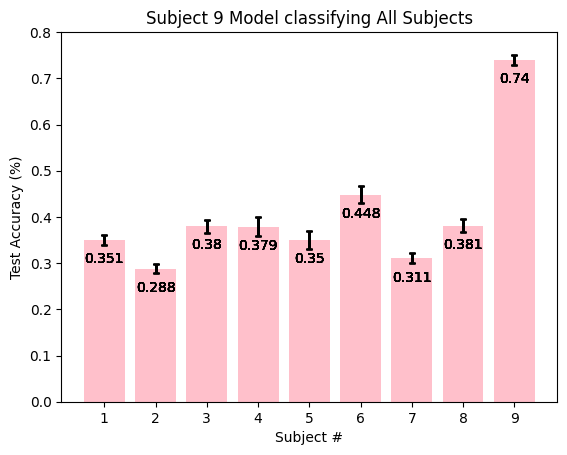

In [141]:
from scipy import stats

plot_subject = 8

for i in range(9):
    bars = plt.bar(np.arange(1, 10), [np.mean(x) for x in single_subject_test_accs[plot_subject]], color='pink')
    plt.errorbar(np.arange(1, 10), [np.mean(x) for x in single_subject_test_accs[plot_subject]], 
                 [stats.sem(x) for x in single_subject_test_accs[plot_subject]], ls='none', 
                 ecolor='black', elinewidth=2, capsize=2, barsabove=True)
    plt.ylim(0, 0.8)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.4, yval - .05, round(yval,3), horizontalalignment="center")
    plt.xticks(np.arange(1,10))
    plt.xlabel("Subject #")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Subject 9 Model classifying All Subjects")

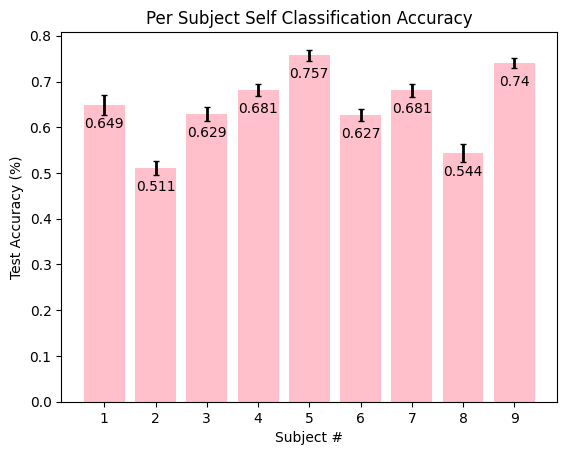

In [131]:
for i in range(9):
    bars = plt.bar(i+1, np.mean(single_subject_test_accs[i][i]), color='pink')
    plt.errorbar(i+1, np.mean(single_subject_test_accs[i][i]), 
                 stats.sem(single_subject_test_accs[i][i]), ls='none', 
                 ecolor='black', elinewidth=2, capsize=2, barsabove=True)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.4, yval - .05, round(yval,3), horizontalalignment="center")
    plt.xticks(np.arange(1,10))
    plt.xlabel("Subject #")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Per Subject Self Classification Accuracy")

In [12]:
# Make data loader for all subjects

# Convert data to tensors
X_tensor_full = torch.FloatTensor(X_test[:,:,:400])
y_tensor_full = torch.LongTensor(y_test)

# Combine X and y into a TensorDataset
dataset_full = TensorDataset(X_tensor_full, y_tensor_full)

# Prepare dataloaders
test_dataloader_full = DataLoader(dataset_full, batch_size=256, shuffle=False)

In [120]:
all_subject_test_accs = []

for i in range(9):
    test_accs = []
    for k in range(15):
        test_acc, _ = evaluate(single_subject_models[i][k], test_dataloader_full, device)
        test_accs.append(test_acc)
    all_subject_test_accs.append(test_accs)

np.save('Per_Subject_Data/all_subject_test_accs.npy', all_subject_test_accs)

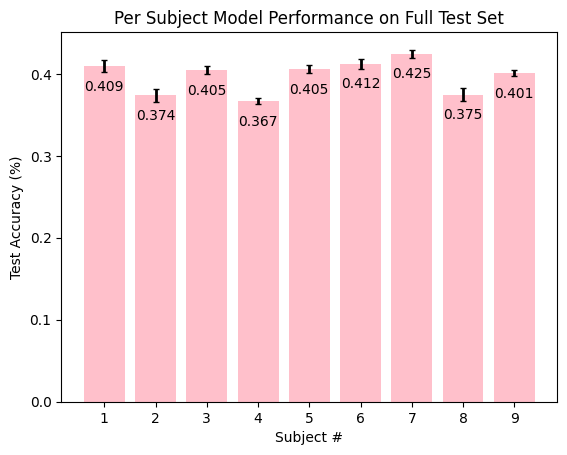

In [130]:
for i in range(9):
    bars = plt.bar(i+1, np.mean(all_subject_test_accs[i]), color='pink')
    plt.errorbar(i+1, np.mean(all_subject_test_accs[i]), 
                 stats.sem(all_subject_test_accs[i]), ls='none', 
                 ecolor='black', elinewidth=2, capsize=2, barsabove=True)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.4, yval - .03, round(yval,3), horizontalalignment="center")
    plt.xticks(np.arange(1,10))
    plt.xlabel("Subject #")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Per Subject Model Performance on Full Test Set")

In [ ]:
all_subject_models = []
num_epochs=300

for i in range(10):
    cnn_all = CNN(input_size=X_train_valid[:,:,:400].shape[1:], N=n_class).to(device)
    valid_acc, trains, valids = fit(cnn_all, X_train_valid[:,:,:400], y_train_valid, device, epochs=num_epochs)
    all_subject_models.append(cnn_all)

np.save('Per_Subject_Data/all_subject_models.npy', all_subject_models)

In [144]:
AA_subject_test_accs = []

for j in range(9):
    test_accs = []
    for k in range(10):
        test_acc, _ = evaluate(all_subject_models[k], single_subject_testers[j], device)
        test_accs.append(test_acc)
    AA_subject_test_accs.append(test_accs)

np.save('Per_Subject_Data/AA_subject_test_accs.npy', AA_subject_test_accs)

In [7]:
all_subject_models = np.load('Per_Subject_Data/all_subject_models.npy', allow_pickle=True)

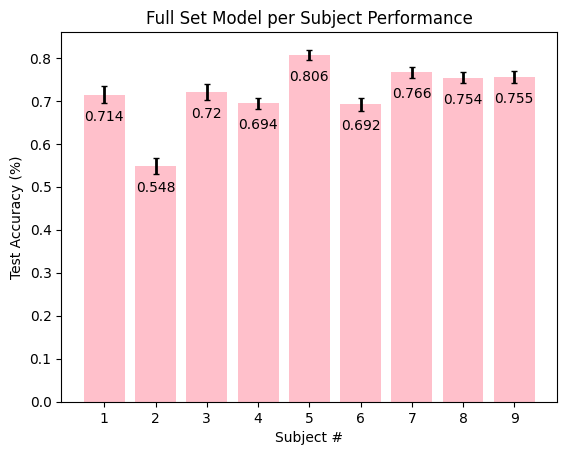

In [151]:
for i in range(9):
    bars = plt.bar(i+1, np.mean(AA_subject_test_accs[i]), color='pink')
    plt.errorbar(i+1, np.mean(AA_subject_test_accs[i]), 
                 stats.sem(AA_subject_test_accs[i]), ls='none', 
                 ecolor='black', elinewidth=2, capsize=2, barsabove=True)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + 0.4, yval - .06, round(yval,3), horizontalalignment="center")
    plt.xticks(np.arange(1,10))
    plt.xlabel("Subject #")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Full Set Model per Subject Performance")

In [13]:
# Mean test accuracy verification, agrees with the time length experiment data

zztest_accs = []
for k in range(10):
    test_acc, _ = evaluate(all_subject_models[k], test_dataloader_full, device)
    zztest_accs.append(test_acc)
print(zztest_accs)

[0.693, 0.71332, 0.69074, 0.7246, 0.73138, 0.69752, 0.74266, 0.70429, 0.72235, 0.73815]
